In [122]:
import pandahouse
import seaborn as sns
import numpy as np
import random
from scipy import stats
import pandas as pd

In [70]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220220'}

In [132]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-02-13' and '2022-02-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [133]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


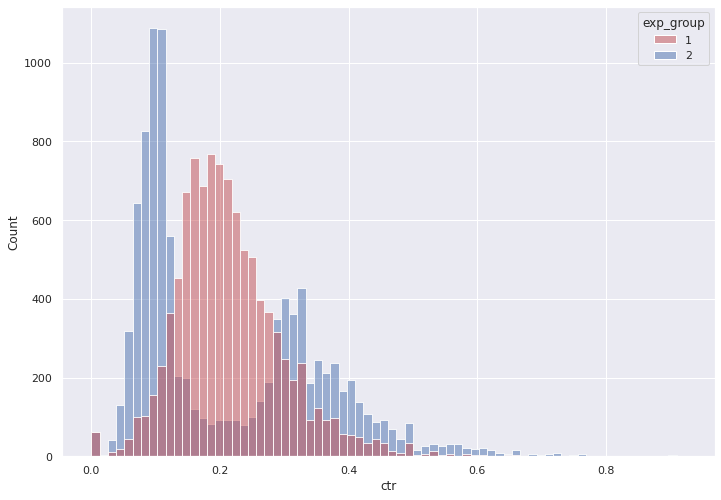

In [73]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [74]:
control = df[df.exp_group == 1].ctr
test = df[df.exp_group == 2].ctr

### Т-тест на сырце

In [95]:
P_raw_t = stats.ttest_ind(control, test, equal_var=False).pvalue
print(P_raw_t)

0.4780623130874935


### МИ - тест на сырце

In [97]:
P_raw_M = stats.mannwhitneyu(control, test, alternative = 'two-sided').pvalue
print(P_raw_M)

6.0376484617779035e-56


### Т-тест на сглаженном CTR

In [77]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [78]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='smothed_ctr'>

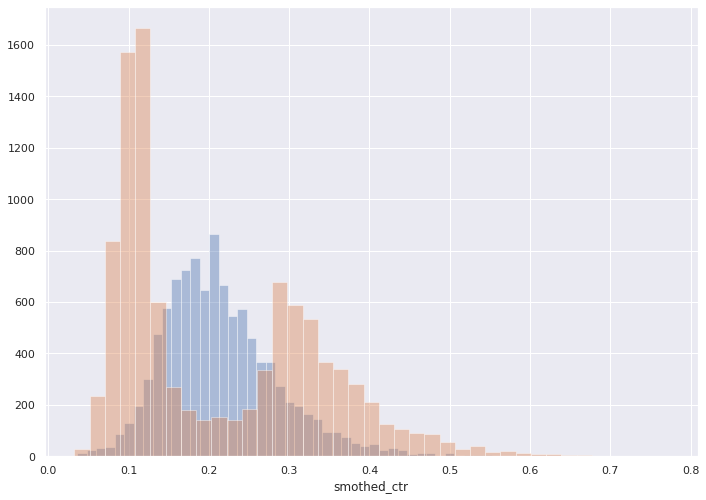

In [79]:
group1 = df[df.exp_group == 1].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2 = df[df.exp_group == 2].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, kde = False)
sns.distplot(group2.smothed_ctr, kde = False)

In [107]:
P_smo_t = stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False).pvalue
print(P_smo_t)

0.12398006885092346


In [108]:
P_smo_M = stats.mannwhitneyu(group1.smothed_ctr, group2.smothed_ctr, alternative = 'two-sided').pvalue
print(P_smo_M)

8.103385180023362e-58


### Бутстреп

In [80]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

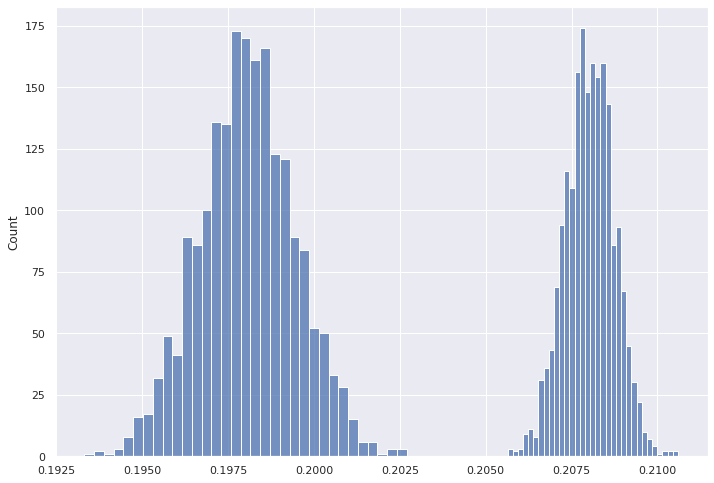

In [81]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

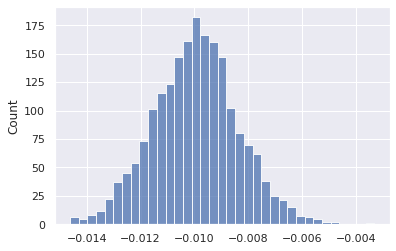

In [82]:
sns.set(rc={'figure.figsize':(6,4)})
sns.histplot(ctr2 - ctr1)

In [112]:
P_boo_t = stats.ttest_ind(ctr1, ctr2, equal_var=False).pvalue
print(P_boo_t)

0.0


In [113]:
P_boo_M = stats.mannwhitneyu(ctr1, ctr2, alternative = 'two-sided').pvalue
print(P_boo_M)

0.0


### Бакетное преобразование

In [83]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-02-13' and '2022-02-19'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df2 = pandahouse.read_clickhouse(q, connection=connection)

In [84]:
stats.mannwhitneyu(df2[df2.exp_group == 1].bucket_ctr, 
                   df2[df2.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [85]:
stats.ttest_ind(df2[df2.exp_group == 1].bucket_ctr, 
                   df2[df2.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

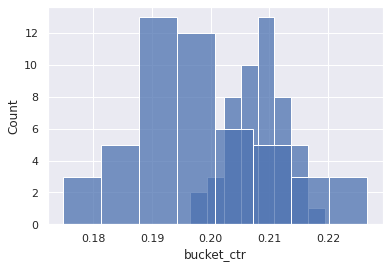

In [88]:
sns.histplot(df2[df2.exp_group == 1].bucket_ctr)
sns.histplot(df2[df2.exp_group == 2].bucket_ctr)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

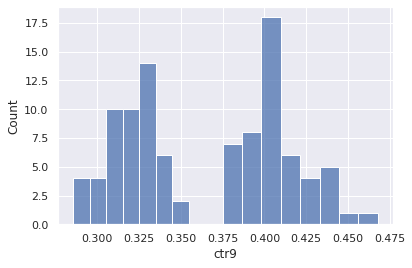

In [90]:
sns.histplot(df2[df2.exp_group == 1].ctr9)
sns.histplot(df2[df2.exp_group == 2].ctr9)

In [114]:
P_back_t = stats.ttest_ind(df2[df2.exp_group == 1].bucket_ctr, df2[df2.exp_group == 2].bucket_ctr, equal_var=False).pvalue
print(P_back_t)

3.4455951649945907e-07


In [115]:
P_back_M = stats.mannwhitneyu(df2[df2.exp_group == 1].bucket_ctr, df2[df2.exp_group == 2].bucket_ctr, alternative = 'two-sided').pvalue
print(P_back_M)

2.859963936492646e-07


In [118]:
P_back_t_Q09 = stats.ttest_ind(df2[df2.exp_group == 1].ctr9, df2[df2.exp_group == 2].ctr9, equal_var=False).pvalue
print(P_back_t_Q09)

1.2945537024964474e-40


In [119]:
P_back_Q09 = stats.mannwhitneyu(df2[df2.exp_group == 1].ctr9, df2[df2.exp_group == 2].ctr9, alternative = 'two-sided').pvalue
print(P_back_Q09)

6.344839189967265e-18


## Итоги

##### 1. Проведены t-тесты и тесты Манна-Уитни.
##### По показателю P-value во всех тестах отклоняется нулевая гипотеза на 1% уровне значимости.

In [131]:
data = {'Data': ['Raw', 'Smooted', 'Bootstrap', 'Backet'],
        'T-test': [P_raw_t, P_smo_t, P_boo_t, P_back_t],
        'MI-test': [P_raw_M, P_smo_M, P_boo_M, P_back_M]
        }

df_pivot = pd.DataFrame(data)
print (df_pivot)

        Data        T-test       MI-test
0        Raw  4.780623e-01  6.037648e-56
1    Smooted  1.239801e-01  8.103385e-58
2  Bootstrap  0.000000e+00  0.000000e+00
3     Backet  3.445595e-07  2.859964e-07


##### 2. При визуальном анализе видно, что тестовой группе свойственно бимодальное распределение, где левый горб ниже по показателю CTR контрольной выборки

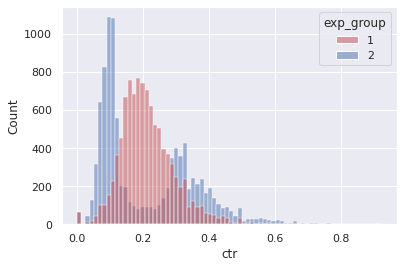

In [134]:
sns.set(rc={'figure.figsize':(6,4)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

##### 3. Биомадальность CTR могла возникнуть в результате дуальной смещенности рекомендательного движка, например:
###### 1) Новости для женщин предлагаются мужчинам
###### 2) Новости по МСК предлагаются жителям СПБ

##### 4. Рекомендую не раскатывать рекомендации, несмотря на общий рост CTR.
##### Причина: Возможное снижение CTR у отдельных групп пользователей.
##### Дальнейшие шаги:
###### 1) Исследовать CTR в разрезе структуры аудитории. Выявить отличительные характеристики в среднем портере пользователя из левого горба группы 2;
###### 2) Провести парные АБ тесты между выделенными группам;
###### 3) Передать команде ML полученные результаты с прокраской где рекомендации не изменили или снизили CTR